### Part 1: Useful Functions

In [12]:
def get_model( temp ):
    '''
    Function opens Phoenix file of specified temperature in 100 Kelvin increments from 2300 to 12000 Kelvin.
    Parameters
    ----------
    temp: str
        Desired temperature in 100K increments from 2300 to 12,000 Kelvin
        
    Returns
    -------
    wavelength: array
        Associated wavelengths for flux measurements from Phoenix FITS file, in Angstroms
        
    flux: array
        Flux measurements from Phoenix FITS file, in erg/s/cm^2
        
    temp: str
        See Parameters
    '''
    model_file = 'Med_Res_10K_Grid/lte0' + temp + '-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
    hdulist = fits.open(model_file)
    flux = hdulist[0].data
    wavelength = np.exp(hdulist[0].header[('CRVAL1')]+hdulist[0].header[('CDELT1')]*np.arange(0,212027))/(10**4)
    return wavelength,flux

In [13]:
def getMag_hires(band,wavelength,flux,unit):
    
    import numpy as np
    import scipy.interpolate as interp
    
    
    
    '''if band=='Ks':
        bandwav,bandpass=np.loadtxt("../DATA/Ks_2MASS.txt",unpack=True)    # micron
        center=2.159
        F0= 4.283E-14        # W cm^-2 micron^-1

    elif band=='H':
        bandwav,bandpass=np.loadtxt("../DATA/H_2MASS.txt",unpack=True)
        center=1.662
        F0= 1.133E-13
    
    elif band=='J':
        bandwav,bandpass=numpy.loadtxt("../DATA/J_2MASS.txt",unpack=True)
        center=1.235
        F0= 3.129E-13'''
    
    #Units of Ks, H and J filters are microns, all other filters in Angstroms
    
    
    if band=='Ks':
        bandwav,bandpass=np.loadtxt('filters/k_filter.txt',unpack=True)
        center=2.159        #micron
        F0=4.283E-14        #W cm^-2 micron^-1

    elif band=='H':
        bandwav,bandpass=np.loadtxt('filters/h_filter.txt',unpack=True)
        center=1.662
        F0=1.133E-13

    elif band=='J':
        bandwav,bandpass=np.loadtxt('filters/j_filter.txt',unpack=True)
        center=1.235
        F0=3.129E-13

    elif band=='U':
        bandwav,bandpass=np.loadtxt('filters/bessell_U.dat',unpack=True)
        center=0.365
        F0=4.19E-12

    elif band=='B':
        bandwav,bandpass=np.loadtxt('filters/bessell_B.dat',unpack=True)
        center=0.445
        F0=6.60E-12

    elif band=='V':
        bandwav,bandpass=np.loadtxt('filters/bessell_V.dat',unpack=True)
        center=0.551
        F0=3.61E-12

    elif band=='R':
        bandwav,bandpass=np.loadtxt('filters/bessell_R.dat',unpack=True)
        center=0.658
        F0=2.25E-12

    elif band=='I':
        bandwav,bandpass=np.loadtxt('filters/bessell_I.dat',unpack=True)
        center=0.806
        F0=1.22E-12
                                      #SDSS centers/widths/F0 from http://www.astronomy.ohio-state.edu/~martini/usefuldata.html
    elif band=='u':                   #NOTE: ugriz filters are on the AB magnitude system, KsHJUBVRI are on the Vega system
        bandwav,bandpass=np.loadtxt('filters/u_filter.txt',unpack=True)
        center=0.356         
        F0=0.8595E-11        
        
    elif band=='g':
        bandwav,bandpass=np.loadtxt('filters/g_filter.txt',unpack=True)
        center=0.483
        F0=0.4669E-11
        
    elif band=='r':
        bandwav,bandpass=np.loadtxt('filters/r_filter.txt',unpack=True)
        center=0.626
        F0=0.2780E-11
    
    elif band=='i':
        bandwav,bandpass=np.loadtxt('filters/i_filter.txt',unpack=True)
        center=0.767
        F0=0.1852E-11
    
    elif band=='z':
        bandwav,bandpass=np.loadtxt('filters/u_filter.txt',unpack=True)
        center=0.910
        F0=0.1315E-11
    
    '''elif band=='Kep':
        bandwav,bandpass=np.loadtxt()
        center=6400/10**4
        F0= '''


    filterband=np.zeros(wavelength.size)
    if band=='U'or band=='B'or band=='V'or band=='R'or band=='I'or band=='u'or band=='g'or band=='r'or band=='i'or band=='z':
        bandwav=[i/1.0E4 for i in bandwav]                     #Convert bandwav from Angstroms to microns
        
    bandinterp=interp.interp1d(bandwav,bandpass)
            #1D function between bandwav(x) and bandpass(y), y=f(x)
        
    inband=np.logical_and(wavelength>bandwav[0],wavelength<bandwav[-1] )
            #Array of 'True's where wavelength is in range of bandwav, 'False's outside of that range. Basically just an index of bandwav in wavelength array
        
    filterband[inband]=bandinterp(wavelength[inband])
            #Ignore all values of bandpass outside of filter range. Now filterband is the same shape as wavelength and flux
        
    
    if unit=='angstrom':  # convert to microns
        wavelength=wavelength/1.0E4
        flux=flux*1.0E4
    
    dwav=np.zeros(wavelength.size)
        
    dwav[0:-1]=wavelength[1:]-wavelength[0:-1]
    

    
    mag=2.5*np.log10((np.sum(F0*dwav*filterband))/(np.sum(flux*dwav*filterband)))
    
    if unit=='angstrom':
        return band,center*1.0E4,mag
    else:
        return band,center,mag 
    

In [31]:
def getFMext(x,R):
    
    """ Fitzpatrick 1999, spectroscopic

        Inputs:  x = inverse wavelength in microns
                R = ratio of A_V to E(B-V)
                
        Outputs:  returns Al/AV in magnitude units
    """
    
    from scipy.interpolate import interp1d
    
    import numpy as np

    f99_anchor = 1.0E4 / np.array([np.inf, 26500., 12200., 6000., 5470., 4670., 4110., 2700., 2600.]) #microns
    #np.array creates an array
    #np.inf sets value to infinity
    #"anchor" wavelengths for the function to come--what is the pattern here?
    #x axis values
    
    a6000=-0.426+1.0044*R
    a5470=-0.050+1.0016*R
    a4670= 0.701+1.0016*R
    a4110= 1.208+1.0032*R-0.00033*R**2
    #for values in array, apply R in some way
    #create new values using R. Where do coefficients of R come from?

    af99_anchor = np.array([0.0, 0.265, 0.829, a6000, a5470, a4670, a4110, 6.265, 6.591])/3.1
    #same shape as previous array so function can be created
    #create a new array, replacing numbers from original array with their corresponding constant
    #divide by 3.1: comparing to the "standard" R value of 3.1?
    #y axis values--tell extinction pattern of "anchor values"?
    
    f=interp1d(f99_anchor,af99_anchor, kind='cubic') 
    #create a 2-variable function between the two arrays, wavelength and magnitude of extinction
    #find a function of frequency (1/wavelength)
    
    return f(1.0/x)
    #A_lambda/A_V:a different value for each input wavelength (continuous function)

In [15]:
import numpy as np
from matplotlib import pyplot as plt
import astropy
import pandas as pd

from astropy.io import fits

%matplotlib inline

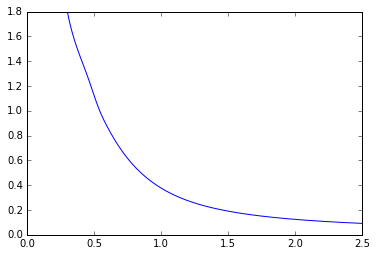

In [27]:
plt.plot(X,getFMext(X,3.1))
#It appears that as wavelength increases, A_l/A_V decreases

In [34]:
getFMext(X,3.1)
#Looks like Al/Av is not defined for wavelengths less than about 0.3 microns
#Need different anchors for hotter stars?

(array([ 1.79947386,  1.7994566 ,  1.79943935, ...,  0.09206476,
         0.09206357,  0.09206238]),
 <scipy.interpolate.interpolate.interp1d at 0x119737c00>)

### Part 2: Spectra Models for Various Extinction Magnitudes

In [16]:
X=get_model('5700')[0]
Y=get_model('5700')[1]

In [17]:
AlAv=getFMext(1.0/X,3)
#Use Z=Y*10.0**(-0.4*AlAv) for reddened spectra
#Multiply exponent by desired magnitude of extinction

In [29]:
Z=Y*10.0**(-0.4*AlAv) #use reddened spectra as new initial spectra

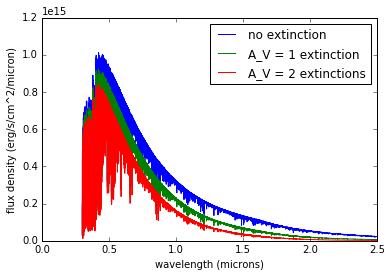

In [36]:
plt.plot(X,Y,label="no extinction")
plt.plot(X,Y*10.0**(-0.4*AlAv),label="A_V = 1 extinction")
plt.plot(X,Y*10.0**(-0.4*AlAv*2),label="A_V = 2 extinctions")
plt.legend()
plt.xlabel("wavelength (microns)")
plt.ylabel("flux density (erg/s/cm^2/micron)")
#plot not doing what expected, looks scaled, not extinguished, before 0.5 microns

### Part 3: Photometry (Band Magnitudes and Extinction)

In [20]:
KmagA=getMag_hires('Ks',X*1.0E4,Y,'angstrom')
VmagA=getMag_hires('V',X,Y,'angstrom')
KmagB=getMag_hires('Ks',X*1.0E4,Z,'angstrom')
VmagB=getMag_hires('V',X,Z,'angstrom')
KmagC=getMag_hires('Ks',X*1.0E4,Q,'angstrom')
VmagC=getMag_hires('V',X,Q,'angstrom')
KmagD=getMag_hires('Ks',X*1.0E4,P,'angstrom')
VmagD=getMag_hires('V',X,P,'angstrom')

|Extinction Magnitude|V mag   |K mag   | V-K  |
|---|---|---|---|
|0  |-75.84|-77.42|1.58|
| 1 |-75.69|-76.22|0.53|
|  2|-75.55|-75.03|-0.52|
|  3|-75.41|-73.84|-1.57|